Loading data from D:\Data\Session_V4.csv...
Loaded 1827780 rows
Date range: 2020-06-10 to 2025-10-14
Available sessions: ['Asian' 'London' 'NY_AM' 'NY_PM']
Preparing data...
Processing 1827780 bars...

Backtest complete. Total trades: 12267

BACKTEST RESULTS

[OVERALL PERFORMANCE]
Total Trades: 12267
Winning Trades: 7246
Losing Trades: 5021
Win Rate: 59.07%

[PROFIT & LOSS]
Total P&L: 533.60 points ($533,600.71)
Average Win: 0.11 points
Average Loss: -0.06 points
Largest Win: 0.89 points
Largest Loss: -0.64 points
Expectancy: 0.04 points per trade

[RISK METRICS]
Max Drawdown: $-1,462.86 (-0.69%)
Profit Factor: 2.79
Sharpe Ratio: 6.56
Sortino Ratio: 18.60
Calmar Ratio: 364.77
Recovery Factor: 364.77

[EXIT BREAKDOWN]
TP1 Exits: 7246
TP2 Exits: 0
SL Exits: 5021
Breakeven Exits: 0

[DIRECTION ANALYSIS]
Long Trades: 6354 (Win Rate: 59.05%, P&L: 264.65)
Short Trades: 5913 (Win Rate: 59.09%, P&L: 268.95)

[TRADE STATISTICS]
Average Trade Duration: 4.6 minutes
Max Consecutive Wins: 17
Max Co

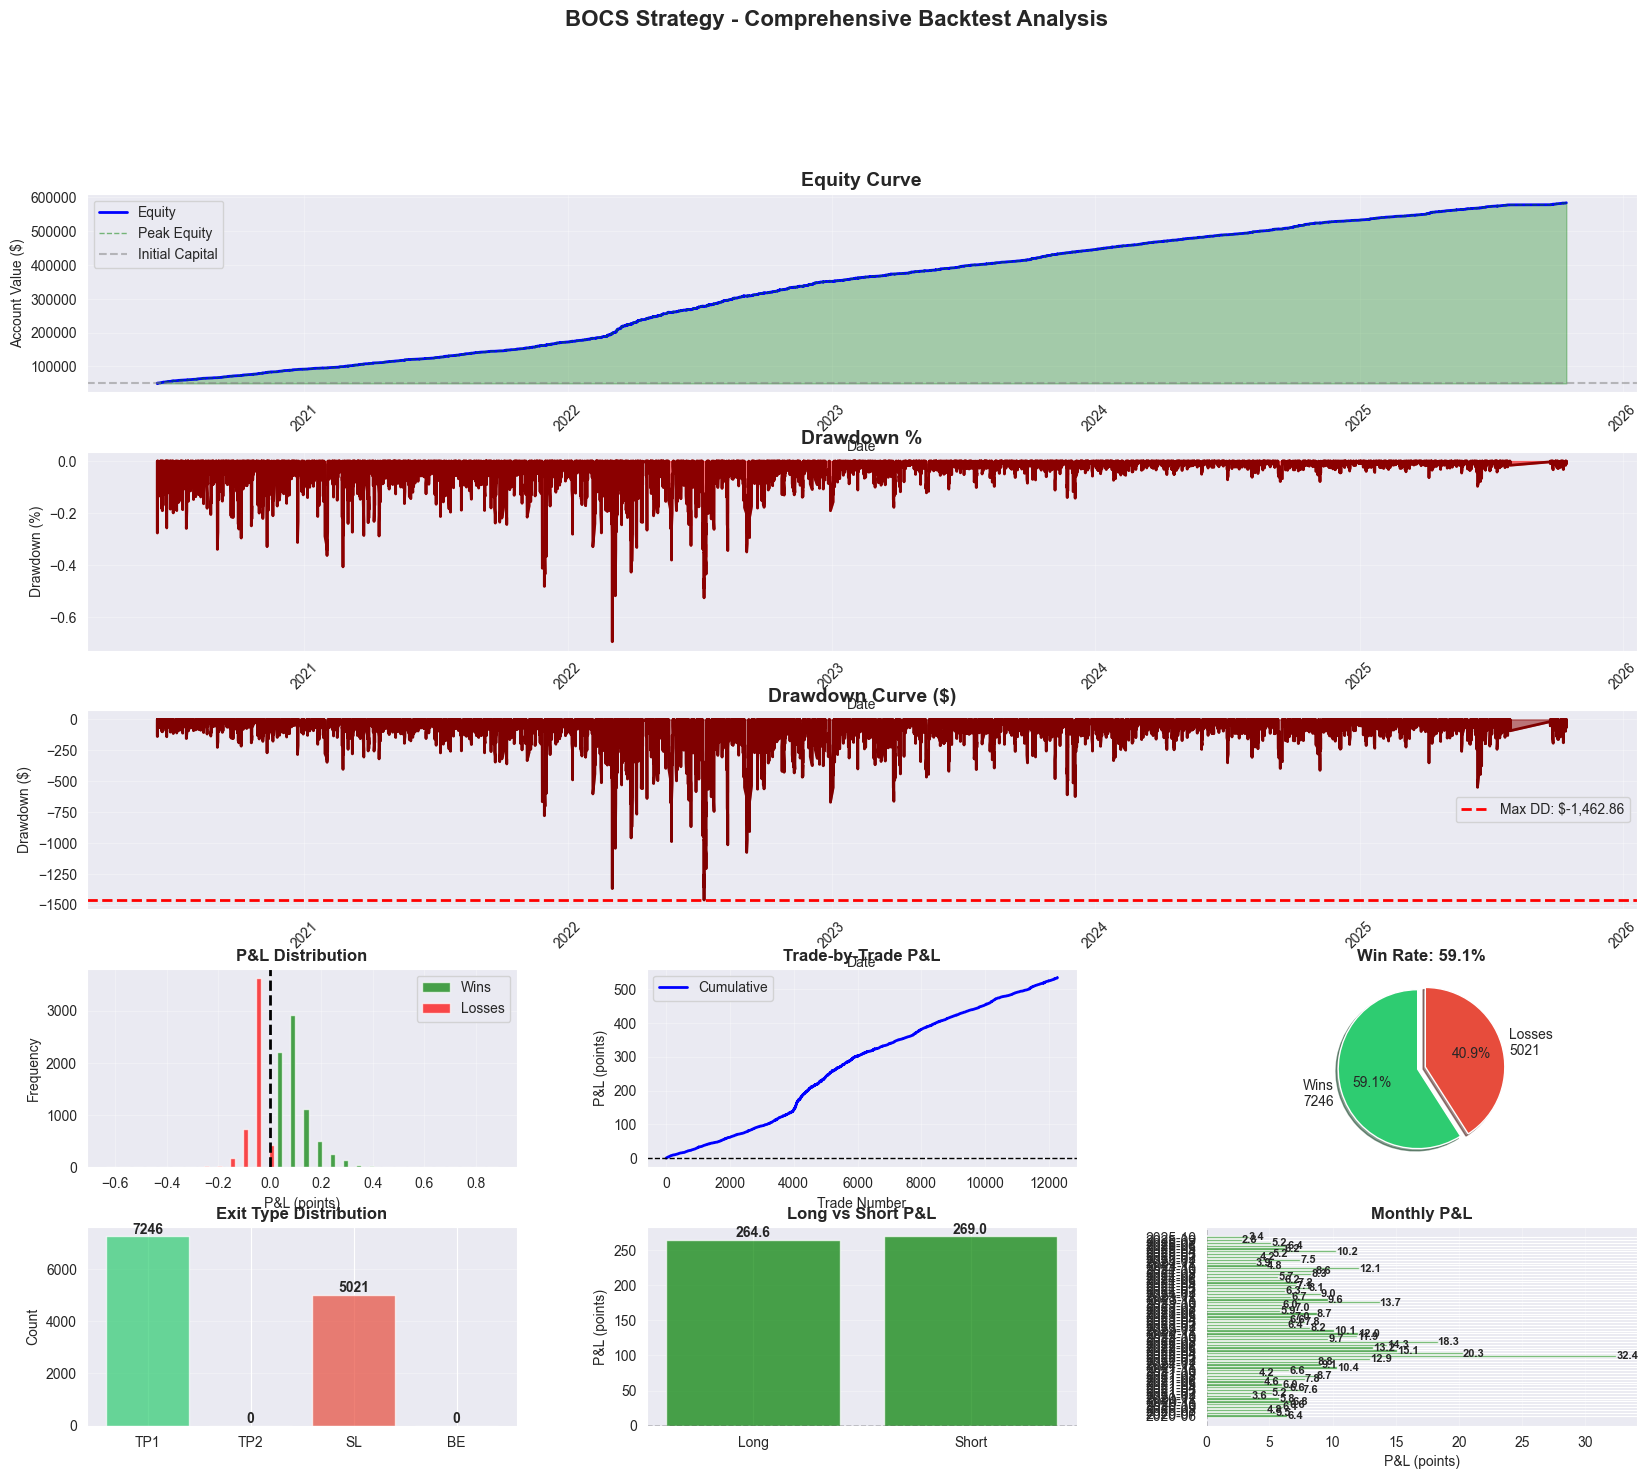


[PLOTTING] Generating trade distribution analysis...
[CHARTS] Trade distribution charts saved to 'bocs_trade_distribution.png'


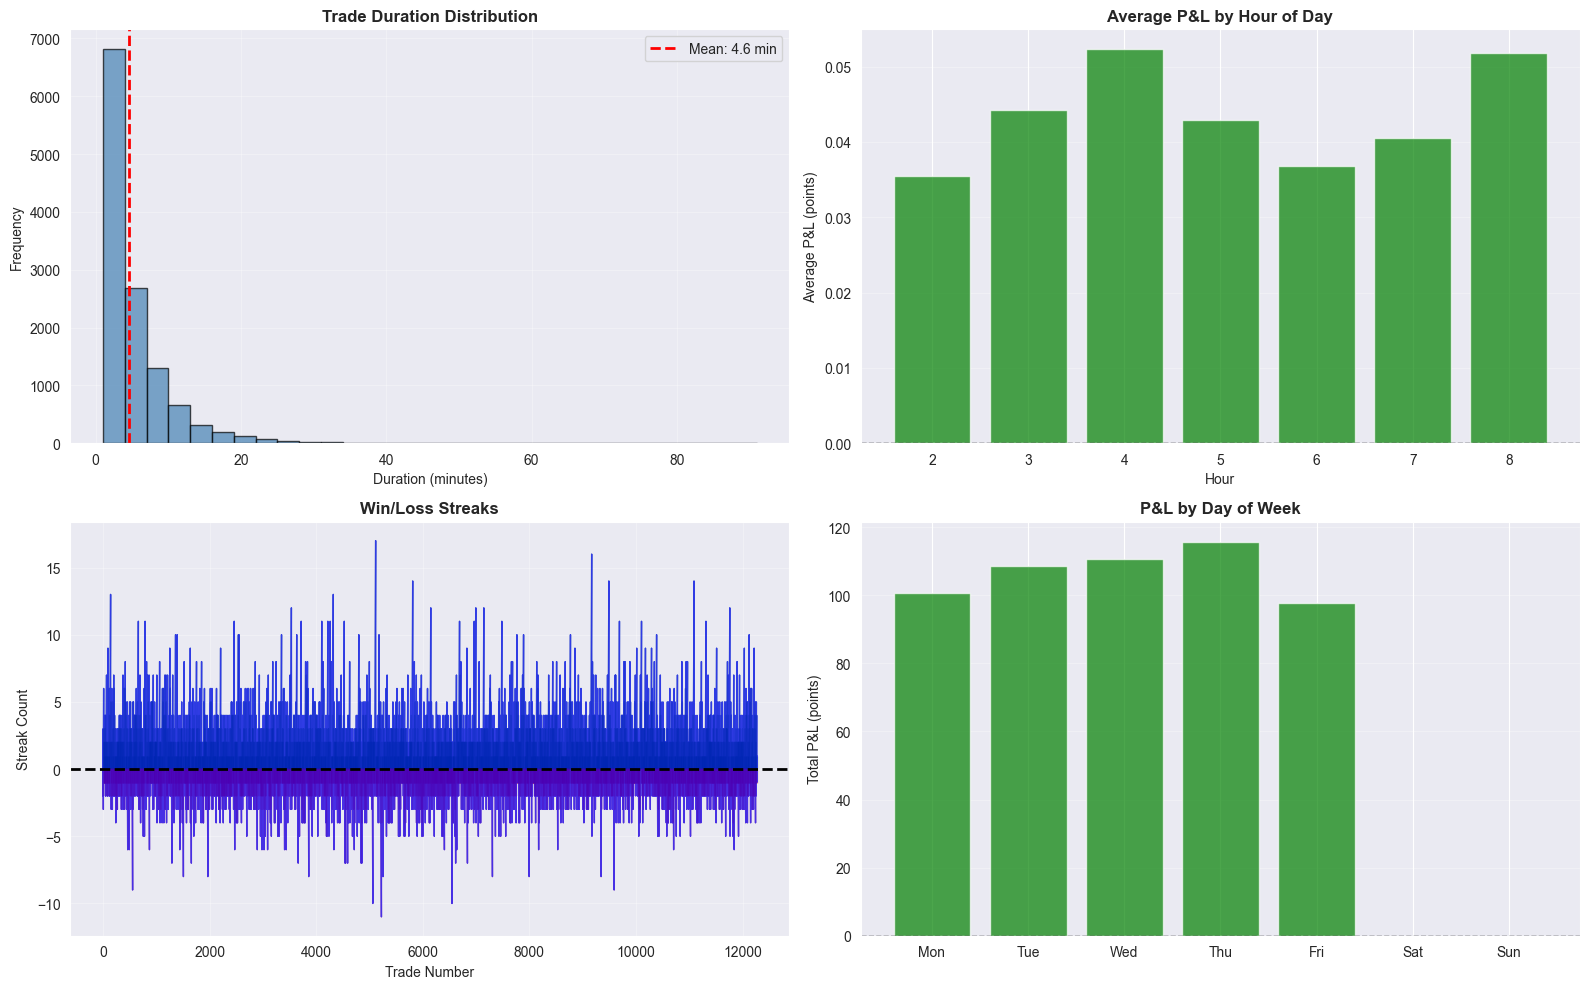


[REPORT] Creating HTML performance report...
[REPORT] HTML performance report saved to 'bocs_performance_report.html'

BACKTEST COMPLETE!

Generated Files:
  1. bocs_trades.csv - All trade details
  2. bocs_backtest_results.png - Comprehensive performance charts
  3. bocs_trade_distribution.png - Trade analysis charts
  4. bocs_performance_report.html - Interactive HTML report

Tip: Open the HTML report in your browser for an interactive view!


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

class BOCSStrategy:
    """
    BOCS Adaptive - Dynamic Volatility-Based Breakout Channel System
    Converted from TradingView Pine Script to Python
    """
    
    def __init__(self, 
                 # Session Filter Settings
                 enable_session_filter=True,
                 allowed_sessions=['London', 'NY AM'],
                 
                 # Main Settings
                 overlap=False,
                 strong=True,
                 length_=100,
                 length=14,
                 
                 # ATR-based TP/SL Settings
                 atr_length=14,
                 tp1_multiplier=2.0,
                 tp2_multiplier=3.0,
                 sl_multiplier=1.0,
                 show_tp2=False,
                 
                 # Volume Analysis
                 vol_scale=0.5):
        
        self.enable_session_filter = enable_session_filter
        self.allowed_sessions = allowed_sessions
        self.overlap = overlap
        self.strong = strong
        self.length_ = length_
        self.length = length
        self.atr_length = atr_length
        self.tp1_multiplier = tp1_multiplier
        self.tp2_multiplier = tp2_multiplier
        self.sl_multiplier = sl_multiplier
        self.show_tp2 = show_tp2
        self.vol_scale = vol_scale
        
        # State tracking
        self.active_channels = []
        self.trades = []
        self.current_position = None
        
    def calculate_atr(self, df, period):
        """Calculate Average True Range"""
        high = df['High']
        low = df['Low']
        close = df['Close'].shift(1)
        
        tr1 = high - low
        tr2 = abs(high - close)
        tr3 = abs(low - close)
        
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window=period).mean()
        
        return atr
    
    def normalize_price(self, df):
        """Normalize price using highest high and lowest low"""
        lowest_low = df['Low'].rolling(window=self.length_).min()
        highest_high = df['High'].rolling(window=self.length_).max()
        
        normalized = (df['Close'] - lowest_low) / (highest_high - lowest_low)
        return normalized
    
    def calculate_volatility_metrics(self, df):
        """Calculate volatility metrics for channel detection"""
        normalized_price = self.normalize_price(df)
        vol = normalized_price.rolling(window=14).std()
        
        # Calculate upper and lower indicators
        upper = vol.rolling(window=self.length + 1).apply(
            lambda x: (np.argmax(x) + self.length) / self.length, raw=True
        )
        lower = vol.rolling(window=self.length + 1).apply(
            lambda x: (np.argmin(x) + self.length) / self.length, raw=True
        )
        
        return vol, upper, lower
    
    def detect_channels(self, df):
        """Detect channel formations"""
        vol, upper, lower = self.calculate_volatility_metrics(df)
        
        df['vol'] = vol
        df['upper'] = upper
        df['lower'] = lower
        
        # Detect crossovers
        df['upper_cross_lower'] = (upper > lower) & (upper.shift(1) <= lower.shift(1))
        df['lower_cross_upper'] = (lower > upper) & (lower.shift(1) <= upper.shift(1))
        
        return df
    
    def calculate_channel_bounds(self, df, start_idx, end_idx):
        """Calculate channel high and low bounds"""
        channel_data = df.iloc[start_idx:end_idx]
        
        h = channel_data['High'].max()
        l = channel_data['Low'].min()
        
        # Calculate volatility adjustment
        atr = df['atr'].iloc[end_idx-1]
        vola = atr / 2
        
        return h, l, vola
    
    def check_session_allowed(self, session):
        """Check if current session is allowed for trading"""
        if not self.enable_session_filter:
            return True
        return session in self.allowed_sessions
    
    def check_breakout(self, price, open_price, channel_top, channel_bottom):
        """Check if price breaks out of channel"""
        if self.strong:
            # Strong close: more than 50% of candle body outside channel
            body_center = (price + open_price) / 2
            return body_center > channel_top or body_center < channel_bottom
        else:
            # Any price movement outside channel
            return price > channel_top or price < channel_bottom
    
    def calculate_tp_sl(self, entry_price, direction, atr):
        """Calculate take profit and stop loss levels based on ATR"""
        tp1_distance = atr * self.tp1_multiplier
        tp2_distance = atr * self.tp2_multiplier
        sl_distance = atr * self.sl_multiplier
        
        if direction == 'LONG':
            tp1 = entry_price + tp1_distance
            tp2 = entry_price + tp2_distance
            sl = entry_price - sl_distance
        else:  # SHORT
            tp1 = entry_price - tp1_distance
            tp2 = entry_price - tp2_distance
            sl = entry_price + sl_distance
        
        return tp1, tp2, sl
    
    def update_position(self, idx, price, direction, tp1, tp2, sl, atr, entry_time):
        """Update current position"""
        self.current_position = {
            'entry_idx': idx,
            'entry_time': entry_time,
            'entry_price': price,
            'direction': direction,
            'tp1': tp1,
            'tp2': tp2,
            'sl': sl,
            'atr': atr,
            'tp1_hit': False,
            'tp2_hit': False,
            'sl_hit': False,
            'sl_moved_to_breakeven': False,
            'qty_remaining': 2 if self.show_tp2 else 1
        }
    
    def check_exit_conditions(self, idx, row):
        """Check if TP or SL levels are hit"""
        if self.current_position is None:
            return None, None
        
        direction = self.current_position['direction']
        high = row['High']
        low = row['Low']
        
        exit_type = None
        exit_price = None
        
        if direction == 'LONG':
            # Check TP1
            if not self.current_position['tp1_hit'] and high >= self.current_position['tp1']:
                self.current_position['tp1_hit'] = True
                self.current_position['sl_moved_to_breakeven'] = True
                self.current_position['qty_remaining'] -= 1
                exit_type = 'TP1'
                exit_price = self.current_position['tp1']
                
                # Record partial exit
                self.trades.append({
                    'entry_time': self.current_position['entry_time'],
                    'exit_time': row['DateTime'],
                    'entry_price': self.current_position['entry_price'],
                    'exit_price': exit_price,
                    'direction': direction,
                    'exit_type': exit_type,
                    'pnl': exit_price - self.current_position['entry_price'],
                    'qty': 1
                })
            
            # Check TP2 (if enabled and remaining position)
            if self.show_tp2 and not self.current_position['tp2_hit'] and self.current_position['qty_remaining'] > 0:
                if high >= self.current_position['tp2']:
                    self.current_position['tp2_hit'] = True
                    exit_type = 'TP2'
                    exit_price = self.current_position['tp2']
                    self.current_position['qty_remaining'] = 0
            
            # Check SL (adjust to breakeven after TP1)
            sl_level = self.current_position['entry_price'] if self.current_position['sl_moved_to_breakeven'] else self.current_position['sl']
            if not self.current_position['sl_hit'] and self.current_position['qty_remaining'] > 0:
                if low <= sl_level:
                    self.current_position['sl_hit'] = True
                    exit_type = 'SL' if not self.current_position['sl_moved_to_breakeven'] else 'BE'
                    exit_price = sl_level
                    self.current_position['qty_remaining'] = 0
        
        else:  # SHORT
            # Check TP1
            if not self.current_position['tp1_hit'] and low <= self.current_position['tp1']:
                self.current_position['tp1_hit'] = True
                self.current_position['sl_moved_to_breakeven'] = True
                self.current_position['qty_remaining'] -= 1
                exit_type = 'TP1'
                exit_price = self.current_position['tp1']
                
                # Record partial exit
                self.trades.append({
                    'entry_time': self.current_position['entry_time'],
                    'exit_time': row['DateTime'],
                    'entry_price': self.current_position['entry_price'],
                    'exit_price': exit_price,
                    'direction': direction,
                    'exit_type': exit_type,
                    'pnl': self.current_position['entry_price'] - exit_price,
                    'qty': 1
                })
            
            # Check TP2 (if enabled and remaining position)
            if self.show_tp2 and not self.current_position['tp2_hit'] and self.current_position['qty_remaining'] > 0:
                if low <= self.current_position['tp2']:
                    self.current_position['tp2_hit'] = True
                    exit_type = 'TP2'
                    exit_price = self.current_position['tp2']
                    self.current_position['qty_remaining'] = 0
            
            # Check SL (adjust to breakeven after TP1)
            sl_level = self.current_position['entry_price'] if self.current_position['sl_moved_to_breakeven'] else self.current_position['sl']
            if not self.current_position['sl_hit'] and self.current_position['qty_remaining'] > 0:
                if high >= sl_level:
                    self.current_position['sl_hit'] = True
                    exit_type = 'SL' if not self.current_position['sl_moved_to_breakeven'] else 'BE'
                    exit_price = sl_level
                    self.current_position['qty_remaining'] = 0
        
        # Close position if no quantity remaining
        if self.current_position['qty_remaining'] == 0:
            if exit_type in ['TP2', 'SL', 'BE']:
                self.trades.append({
                    'entry_time': self.current_position['entry_time'],
                    'exit_time': row['DateTime'],
                    'entry_price': self.current_position['entry_price'],
                    'exit_price': exit_price,
                    'direction': direction,
                    'exit_type': exit_type,
                    'pnl': (exit_price - self.current_position['entry_price']) if direction == 'LONG' else (self.current_position['entry_price'] - exit_price),
                    'qty': 1
                })
            self.current_position = None
            return exit_type, exit_price
        
        return exit_type, exit_price
    
    def backtest(self, df):
        """Run backtest on historical data"""
        print("Preparing data...")
        
        # Create DateTime column
        df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        df = df.sort_values('DateTime').reset_index(drop=True)
        
        # Calculate ATR
        df['atr'] = self.calculate_atr(df, self.atr_length)
        
        # Calculate volume metrics
        df['vol_sma'] = df['Volume'].rolling(window=20).mean()
        
        # Detect channels
        df = self.detect_channels(df)
        
        print(f"Processing {len(df)} bars...")
        
        # Track channel formation
        channel_start_idx = None
        channel_duration = 0
        
        for idx in range(self.length + 1, len(df)):
            row = df.iloc[idx]
            
            # Check for exits first if position exists
            if self.current_position is not None:
                exit_type, exit_price = self.check_exit_conditions(idx, row)
            
            # Skip if session filter is enabled and current session not allowed
            if not self.check_session_allowed(row['Session']):
                continue
            
            # Detect new channel formation (lower crosses above upper)
            if df['lower_cross_upper'].iloc[idx]:
                # Calculate duration since last upper_cross_lower
                last_cross_idx = None
                for i in range(idx-1, max(0, idx-self.length*2), -1):
                    if df['upper_cross_lower'].iloc[i]:
                        last_cross_idx = i
                        break
                
                if last_cross_idx is not None:
                    duration = idx - last_cross_idx
                    
                    if duration > 10:  # Minimum duration requirement
                        # Calculate channel bounds
                        h, l, vola = self.calculate_channel_bounds(df, last_cross_idx, idx)
                        
                        # Store channel
                        channel = {
                            'start_idx': last_cross_idx,
                            'end_idx': idx,
                            'high': h,
                            'low': l,
                            'upper_bound': h,
                            'lower_bound': l,
                            'vola': vola,
                            'active': True
                        }
                        
                        # Check overlap condition
                        if self.overlap or len(self.active_channels) == 0:
                            self.active_channels.append(channel)
                        else:
                            # Remove old channels if overlap not allowed
                            self.active_channels = [channel]
            
            # Check for breakouts in active channels
            if len(self.active_channels) > 0 and self.current_position is None:
                for channel in self.active_channels[:]:
                    if not channel['active']:
                        continue
                    
                    close_price = row['Close']
                    open_price = row['Open']
                    
                    # Bullish breakout
                    if self.check_breakout(close_price, open_price, channel['upper_bound'], channel['lower_bound']):
                        if (self.strong and (close_price + open_price) / 2 > channel['upper_bound']) or \
                           (not self.strong and close_price > channel['upper_bound']):
                            
                            # Enter long position
                            entry_price = channel['upper_bound']
                            atr = row['atr']
                            
                            if not np.isnan(atr):
                                tp1, tp2, sl = self.calculate_tp_sl(entry_price, 'LONG', atr)
                                self.update_position(idx, entry_price, 'LONG', tp1, tp2, sl, atr, row['DateTime'])
                                
                                # Remove channel
                                channel['active'] = False
                                self.active_channels.remove(channel)
                                break
                        
                        # Bearish breakout
                        elif (self.strong and (close_price + open_price) / 2 < channel['lower_bound']) or \
                             (not self.strong and close_price < channel['lower_bound']):
                            
                            # Enter short position
                            entry_price = channel['lower_bound']
                            atr = row['atr']
                            
                            if not np.isnan(atr):
                                tp1, tp2, sl = self.calculate_tp_sl(entry_price, 'SHORT', atr)
                                self.update_position(idx, entry_price, 'SHORT', tp1, tp2, sl, atr, row['DateTime'])
                                
                                # Remove channel
                                channel['active'] = False
                                self.active_channels.remove(channel)
                                break
                    
                    # Update channel end
                    channel['end_idx'] = idx
        
        print(f"\nBacktest complete. Total trades: {len(self.trades)}")
        return self.trades
    
    def calculate_statistics(self, trades_df, point_value=1000, initial_capital=50000):
        """Calculate trading statistics"""
        if len(trades_df) == 0:
            print("No trades to analyze")
            return None, None
        
        stats = {}
        
        # Basic metrics
        stats['total_trades'] = len(trades_df)
        stats['winning_trades'] = len(trades_df[trades_df['pnl'] > 0])
        stats['losing_trades'] = len(trades_df[trades_df['pnl'] < 0])
        stats['win_rate'] = stats['winning_trades'] / stats['total_trades'] * 100 if stats['total_trades'] > 0 else 0
        
        # P&L metrics (in points and dollars)
        trades_df['pnl_dollars'] = trades_df['pnl'] * point_value
        stats['total_pnl'] = trades_df['pnl'].sum()
        stats['total_pnl_dollars'] = trades_df['pnl_dollars'].sum()
        stats['avg_win'] = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if stats['winning_trades'] > 0 else 0
        stats['avg_loss'] = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if stats['losing_trades'] > 0 else 0
        stats['largest_win'] = trades_df['pnl'].max()
        stats['largest_loss'] = trades_df['pnl'].min()
        
        # Risk metrics
        if stats['avg_loss'] != 0:
            stats['profit_factor'] = abs(stats['avg_win'] * stats['winning_trades'] / (stats['avg_loss'] * stats['losing_trades']))
        else:
            stats['profit_factor'] = float('inf') if stats['winning_trades'] > 0 else 0
        
        # Exit type breakdown
        stats['tp1_exits'] = len(trades_df[trades_df['exit_type'] == 'TP1'])
        stats['tp2_exits'] = len(trades_df[trades_df['exit_type'] == 'TP2'])
        stats['sl_exits'] = len(trades_df[trades_df['exit_type'] == 'SL'])
        stats['be_exits'] = len(trades_df[trades_df['exit_type'] == 'BE'])
        
        # Direction breakdown
        long_trades = trades_df[trades_df['direction'] == 'LONG']
        short_trades = trades_df[trades_df['direction'] == 'SHORT']
        
        stats['long_trades'] = len(long_trades)
        stats['long_win_rate'] = len(long_trades[long_trades['pnl'] > 0]) / len(long_trades) * 100 if len(long_trades) > 0 else 0
        stats['long_pnl'] = long_trades['pnl'].sum()
        
        stats['short_trades'] = len(short_trades)
        stats['short_win_rate'] = len(short_trades[short_trades['pnl'] > 0]) / len(short_trades) * 100 if len(short_trades) > 0 else 0
        stats['short_pnl'] = short_trades['pnl'].sum()
        
        # Calculate equity curve
        trades_df = trades_df.sort_values('exit_time').reset_index(drop=True)
        trades_df['cumulative_pnl'] = trades_df['pnl_dollars'].cumsum()
        trades_df['equity'] = initial_capital + trades_df['cumulative_pnl']
        
        # Drawdown calculation
        trades_df['peak'] = trades_df['equity'].cummax()
        trades_df['drawdown'] = trades_df['equity'] - trades_df['peak']
        trades_df['drawdown_pct'] = (trades_df['drawdown'] / trades_df['peak']) * 100
        
        stats['max_drawdown'] = trades_df['drawdown'].min()
        stats['max_drawdown_pct'] = trades_df['drawdown_pct'].min()
        
        # Sharpe Ratio (annualized, assuming 252 trading days)
        if len(trades_df) > 1:
            returns = trades_df['pnl_dollars'].values
            if np.std(returns) > 0:
                stats['sharpe_ratio'] = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
            else:
                stats['sharpe_ratio'] = 0
        else:
            stats['sharpe_ratio'] = 0
        
        # Sortino Ratio (downside deviation)
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 0 and np.std(downside_returns) > 0:
            stats['sortino_ratio'] = (np.mean(returns) / np.std(downside_returns)) * np.sqrt(252)
        else:
            stats['sortino_ratio'] = 0
        
        # Calmar Ratio (return / max drawdown)
        if stats['max_drawdown'] != 0:
            stats['calmar_ratio'] = stats['total_pnl_dollars'] / abs(stats['max_drawdown'])
        else:
            stats['calmar_ratio'] = 0
        
        # Average trade duration
        trades_df['duration'] = (pd.to_datetime(trades_df['exit_time']) - 
                                 pd.to_datetime(trades_df['entry_time'])).dt.total_seconds() / 60
        stats['avg_trade_duration'] = trades_df['duration'].mean()
        
        # Consecutive wins/losses
        trades_df['win'] = (trades_df['pnl'] > 0).astype(int)
        trades_df['loss'] = (trades_df['pnl'] < 0).astype(int)
        
        max_consecutive_wins = 0
        max_consecutive_losses = 0
        current_wins = 0
        current_losses = 0
        
        for win, loss in zip(trades_df['win'], trades_df['loss']):
            if win:
                current_wins += 1
                current_losses = 0
                max_consecutive_wins = max(max_consecutive_wins, current_wins)
            elif loss:
                current_losses += 1
                current_wins = 0
                max_consecutive_losses = max(max_consecutive_losses, current_losses)
        
        stats['max_consecutive_wins'] = max_consecutive_wins
        stats['max_consecutive_losses'] = max_consecutive_losses
        
        # Recovery factor
        stats['recovery_factor'] = stats['total_pnl_dollars'] / abs(stats['max_drawdown']) if stats['max_drawdown'] != 0 else 0
        
        # Expectancy
        stats['expectancy'] = (stats['win_rate']/100 * stats['avg_win']) + ((1 - stats['win_rate']/100) * stats['avg_loss'])
        
        return stats, trades_df
    
    def print_statistics(self, stats):
        """Print formatted statistics"""
        if stats is None:
            return
        
        print("\n" + "="*60)
        print("BACKTEST RESULTS")
        print("="*60)
        
        print(f"\n[OVERALL PERFORMANCE]")
        print(f"Total Trades: {stats['total_trades']}")
        print(f"Winning Trades: {stats['winning_trades']}")
        print(f"Losing Trades: {stats['losing_trades']}")
        print(f"Win Rate: {stats['win_rate']:.2f}%")
        
        print(f"\n[PROFIT & LOSS]")
        print(f"Total P&L: {stats['total_pnl']:.2f} points (${stats['total_pnl_dollars']:,.2f})")
        print(f"Average Win: {stats['avg_win']:.2f} points")
        print(f"Average Loss: {stats['avg_loss']:.2f} points")
        print(f"Largest Win: {stats['largest_win']:.2f} points")
        print(f"Largest Loss: {stats['largest_loss']:.2f} points")
        print(f"Expectancy: {stats['expectancy']:.2f} points per trade")
        
        print(f"\n[RISK METRICS]")
        print(f"Max Drawdown: ${stats['max_drawdown']:,.2f} ({stats['max_drawdown_pct']:.2f}%)")
        print(f"Profit Factor: {stats['profit_factor']:.2f}")
        print(f"Sharpe Ratio: {stats['sharpe_ratio']:.2f}")
        print(f"Sortino Ratio: {stats['sortino_ratio']:.2f}")
        print(f"Calmar Ratio: {stats['calmar_ratio']:.2f}")
        print(f"Recovery Factor: {stats['recovery_factor']:.2f}")
        
        print(f"\n[EXIT BREAKDOWN]")
        print(f"TP1 Exits: {stats['tp1_exits']}")
        print(f"TP2 Exits: {stats['tp2_exits']}")
        print(f"SL Exits: {stats['sl_exits']}")
        print(f"Breakeven Exits: {stats['be_exits']}")
        
        print(f"\n[DIRECTION ANALYSIS]")
        print(f"Long Trades: {stats['long_trades']} (Win Rate: {stats['long_win_rate']:.2f}%, P&L: {stats['long_pnl']:.2f})")
        print(f"Short Trades: {stats['short_trades']} (Win Rate: {stats['short_win_rate']:.2f}%, P&L: {stats['short_pnl']:.2f})")
        
        print(f"\n[TRADE STATISTICS]")
        print(f"Average Trade Duration: {stats['avg_trade_duration']:.1f} minutes")
        print(f"Max Consecutive Wins: {stats['max_consecutive_wins']}")
        print(f"Max Consecutive Losses: {stats['max_consecutive_losses']}")
        
        print("\n" + "="*60)
    
    def plot_results(self, trades_df, stats, initial_capital=50000):
        """Create comprehensive visualization of backtest results"""
        
        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        gs = GridSpec(5, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # 1. Equity Curve
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(trades_df['exit_time'], trades_df['equity'], linewidth=2, color='blue', label='Equity')
        ax1.plot(trades_df['exit_time'], trades_df['peak'], linewidth=1, color='green', 
                linestyle='--', alpha=0.5, label='Peak Equity')
        ax1.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.fill_between(trades_df['exit_time'], initial_capital, trades_df['equity'], 
                         where=trades_df['equity'] >= initial_capital, alpha=0.3, color='green', interpolate=True)
        ax1.fill_between(trades_df['exit_time'], initial_capital, trades_df['equity'], 
                         where=trades_df['equity'] < initial_capital, alpha=0.3, color='red', interpolate=True)
        ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Account Value ($)')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Drawdown % Chart
        ax2 = fig.add_subplot(gs[1, :])
        ax2.fill_between(trades_df['exit_time'], 0, trades_df['drawdown_pct'], 
                         color='red', alpha=0.5)
        ax2.plot(trades_df['exit_time'], trades_df['drawdown_pct'], linewidth=2, color='darkred')
        ax2.set_title('Drawdown %', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. NEW: Drawdown $ Curve
        ax_dd = fig.add_subplot(gs[2, :])
        ax_dd.fill_between(trades_df['exit_time'], 0, trades_df['drawdown'], 
                          color='darkred', alpha=0.5)
        ax_dd.plot(trades_df['exit_time'], trades_df['drawdown'], linewidth=2, color='maroon')
        ax_dd.axhline(y=stats['max_drawdown'], color='red', linestyle='--', linewidth=2,
                     label=f"Max DD: ${stats['max_drawdown']:,.2f}")
        ax_dd.set_title('Drawdown Curve ($)', fontsize=14, fontweight='bold')
        ax_dd.set_xlabel('Date')
        ax_dd.set_ylabel('Drawdown ($)')
        ax_dd.legend(loc='best')
        ax_dd.grid(True, alpha=0.3)
        ax_dd.tick_params(axis='x', rotation=45)
        
        # 4. Trade P&L Distribution
        ax3 = fig.add_subplot(gs[3, 0])
        wins = trades_df[trades_df['pnl'] > 0]['pnl']
        losses = trades_df[trades_df['pnl'] < 0]['pnl']
        ax3.hist([wins, losses], bins=30, label=['Wins', 'Losses'], 
                color=['green', 'red'], alpha=0.7)
        ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax3.set_title('P&L Distribution', fontsize=12, fontweight='bold')
        ax3.set_xlabel('P&L (points)')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 5. Cumulative P&L by Trade
        ax4 = fig.add_subplot(gs[3, 1])
        colors = ['green' if x > 0 else 'red' for x in trades_df['pnl']]
        ax4.bar(range(len(trades_df)), trades_df['pnl'], color=colors, alpha=0.6)
        ax4.plot(range(len(trades_df)), trades_df['pnl'].cumsum(), 
                color='blue', linewidth=2, label='Cumulative')
        ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax4.set_title('Trade-by-Trade P&L', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Trade Number')
        ax4.set_ylabel('P&L (points)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 6. Win/Loss Ratio Pie Chart
        ax5 = fig.add_subplot(gs[3, 2])
        sizes = [stats['winning_trades'], stats['losing_trades']]
        labels = [f"Wins\n{stats['winning_trades']}", f"Losses\n{stats['losing_trades']}"]
        colors_pie = ['#2ecc71', '#e74c3c']
        explode = (0.05, 0.05)
        ax5.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
               shadow=True, startangle=90)
        ax5.set_title(f'Win Rate: {stats["win_rate"]:.1f}%', fontsize=12, fontweight='bold')
        
        # 7. Exit Type Breakdown
        ax6 = fig.add_subplot(gs[4, 0])
        exit_types = ['TP1', 'TP2', 'SL', 'BE']
        exit_counts = [stats['tp1_exits'], stats['tp2_exits'], 
                      stats['sl_exits'], stats['be_exits']]
        colors_bar = ['#2ecc71', '#27ae60', '#e74c3c', '#f39c12']
        bars = ax6.bar(exit_types, exit_counts, color=colors_bar, alpha=0.7)
        ax6.set_title('Exit Type Distribution', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Count')
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')
        
        # 8. Long vs Short Performance
        ax7 = fig.add_subplot(gs[4, 1])
        directions = ['Long', 'Short']
        pnl_values = [stats['long_pnl'], stats['short_pnl']]
        colors_dir = ['green' if x > 0 else 'red' for x in pnl_values]
        bars = ax7.bar(directions, pnl_values, color=colors_dir, alpha=0.7)
        ax7.set_title('Long vs Short P&L', fontsize=12, fontweight='bold')
        ax7.set_ylabel('P&L (points)')
        ax7.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax7.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
        
        # 9. Monthly Returns Heatmap
        ax8 = fig.add_subplot(gs[4, 2])
        trades_df['month'] = pd.to_datetime(trades_df['exit_time']).dt.to_period('M')
        monthly_pnl = trades_df.groupby('month')['pnl'].sum()
        
        if len(monthly_pnl) > 0:
            months = [str(m) for m in monthly_pnl.index]
            values = monthly_pnl.values
            colors_monthly = ['green' if x > 0 else 'red' for x in values]
            
            bars = ax8.barh(months, values, color=colors_monthly, alpha=0.7)
            ax8.set_title('Monthly P&L', fontsize=12, fontweight='bold')
            ax8.set_xlabel('P&L (points)')
            ax8.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax8.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax8.text(width, bar.get_y() + bar.get_height()/2.,
                        f'{width:.1f}',
                        ha='left' if width > 0 else 'right', 
                        va='center', fontweight='bold', fontsize=8)
        
        plt.suptitle('BOCS Strategy - Comprehensive Backtest Analysis', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        # Save figure
        plt.savefig('bocs_backtest_results.png', dpi=300, bbox_inches='tight')
        print("\n[CHARTS] Comprehensive charts saved to 'bocs_backtest_results.png'")
        
        plt.show()
    
    def plot_trade_distribution(self, trades_df):
        """Plot additional trade analysis charts"""
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # 1. Trade duration distribution
        ax1 = axes[0, 0]
        trades_df['duration'] = (pd.to_datetime(trades_df['exit_time']) - 
                                 pd.to_datetime(trades_df['entry_time'])).dt.total_seconds() / 60
        ax1.hist(trades_df['duration'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.axvline(trades_df['duration'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {trades_df["duration"].mean():.1f} min')
        ax1.set_title('Trade Duration Distribution', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Duration (minutes)')
        ax1.set_ylabel('Frequency')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. P&L by time of day
        ax2 = axes[0, 1]
        trades_df['hour'] = pd.to_datetime(trades_df['entry_time']).dt.hour
        hourly_pnl = trades_df.groupby('hour')['pnl'].mean()
        colors = ['green' if x > 0 else 'red' for x in hourly_pnl.values]
        ax2.bar(hourly_pnl.index, hourly_pnl.values, color=colors, alpha=0.7)
        ax2.set_title('Average P&L by Hour of Day', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Hour')
        ax2.set_ylabel('Average P&L (points)')
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Consecutive wins/losses
        ax3 = axes[1, 0]
        trades_df['win'] = (trades_df['pnl'] > 0).astype(int)
        
        # Calculate streaks
        streaks = []
        current_streak = 0
        for win in trades_df['win']:
            if win:
                current_streak = current_streak + 1 if current_streak > 0 else 1
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
            streaks.append(current_streak)
        
        ax3.plot(streaks, linewidth=1, color='blue', alpha=0.7)
        ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)
        ax3.fill_between(range(len(streaks)), 0, streaks, 
                        where=np.array(streaks) > 0, color='green', alpha=0.3)
        ax3.fill_between(range(len(streaks)), 0, streaks, 
                        where=np.array(streaks) < 0, color='red', alpha=0.3)
        ax3.set_title('Win/Loss Streaks', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Trade Number')
        ax3.set_ylabel('Streak Count')
        ax3.grid(True, alpha=0.3)
        
        # 4. P&L by day of week
        ax4 = axes[1, 1]
        trades_df['day_of_week'] = pd.to_datetime(trades_df['entry_time']).dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_pnl = trades_df.groupby('day_of_week')['pnl'].sum().reindex(day_order, fill_value=0)
        colors = ['green' if x > 0 else 'red' for x in daily_pnl.values]
        ax4.bar(range(len(daily_pnl)), daily_pnl.values, color=colors, alpha=0.7)
        ax4.set_xticks(range(len(daily_pnl)))
        ax4.set_xticklabels([day[:3] for day in daily_pnl.index], rotation=0)
        ax4.set_title('P&L by Day of Week', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Total P&L (points)')
        ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('bocs_trade_distribution.png', dpi=300, bbox_inches='tight')
        print("[CHARTS] Trade distribution charts saved to 'bocs_trade_distribution.png'")
        plt.show()
    
    def create_performance_report(self, trades_df, stats, initial_capital=50000):
        """Create a detailed HTML performance report"""
        
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <meta charset="UTF-8">
            <title>BOCS Strategy Performance Report</title>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 40px;
                    background-color: #f5f5f5;
                }}
                .header {{
                    background-color: #2c3e50;
                    color: white;
                    padding: 20px;
                    text-align: center;
                    border-radius: 10px;
                }}
                .section {{
                    background-color: white;
                    margin: 20px 0;
                    padding: 20px;
                    border-radius: 10px;
                    box-shadow: 0 2px 5px rgba(0,0,0,0.1);
                }}
                .metric {{
                    display: inline-block;
                    margin: 10px 20px;
                    min-width: 200px;
                }}
                .metric-label {{
                    font-weight: bold;
                    color: #7f8c8d;
                }}
                .metric-value {{
                    font-size: 24px;
                    color: #2c3e50;
                }}
                .positive {{
                    color: #27ae60;
                }}
                .negative {{
                    color: #e74c3c;
                }}
                table {{
                    width: 100%;
                    border-collapse: collapse;
                }}
                th, td {{
                    padding: 12px;
                    text-align: left;
                    border-bottom: 1px solid #ddd;
                }}
                th {{
                    background-color: #34495e;
                    color: white;
                }}
                tr:hover {{
                    background-color: #f5f5f5;
                }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>BOCS Strategy Performance Report</h1>
                <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>
            
            <div class="section">
                <h2>Summary Statistics</h2>
                <div class="metric">
                    <div class="metric-label">Initial Capital</div>
                    <div class="metric-value">${initial_capital:,.0f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Final Capital</div>
                    <div class="metric-value {'positive' if stats['total_pnl_dollars'] > 0 else 'negative'}">${initial_capital + stats['total_pnl_dollars']:,.0f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Total Return</div>
                    <div class="metric-value {'positive' if stats['total_pnl_dollars'] > 0 else 'negative'}">{(stats['total_pnl_dollars']/initial_capital*100):.2f}%</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Total Trades</div>
                    <div class="metric-value">{stats['total_trades']}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Win Rate</div>
                    <div class="metric-value {'positive' if stats['win_rate'] > 50 else 'negative'}">{stats['win_rate']:.2f}%</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Profit Factor</div>
                    <div class="metric-value {'positive' if stats['profit_factor'] > 1 else 'negative'}">{stats['profit_factor']:.2f}</div>
                </div>
            </div>
            
            <div class="section">
                <h2>Profit &amp; Loss</h2>
                <div class="metric">
                    <div class="metric-label">Total P&amp;L</div>
                    <div class="metric-value {'positive' if stats['total_pnl_dollars'] > 0 else 'negative'}">${stats['total_pnl_dollars']:,.2f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Average Win</div>
                    <div class="metric-value positive">{stats['avg_win']:.2f} pts</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Average Loss</div>
                    <div class="metric-value negative">{stats['avg_loss']:.2f} pts</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Largest Win</div>
                    <div class="metric-value positive">{stats['largest_win']:.2f} pts</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Largest Loss</div>
                    <div class="metric-value negative">{stats['largest_loss']:.2f} pts</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Expectancy</div>
                    <div class="metric-value {'positive' if stats['expectancy'] > 0 else 'negative'}">{stats['expectancy']:.2f} pts</div>
                </div>
            </div>
            
            <div class="section">
                <h2>Risk Metrics</h2>
                <div class="metric">
                    <div class="metric-label">Max Drawdown</div>
                    <div class="metric-value negative">${stats['max_drawdown']:,.2f} ({stats['max_drawdown_pct']:.2f}%)</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Sharpe Ratio</div>
                    <div class="metric-value {'positive' if stats['sharpe_ratio'] > 1 else 'negative'}">{stats['sharpe_ratio']:.2f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Sortino Ratio</div>
                    <div class="metric-value {'positive' if stats['sortino_ratio'] > 1 else 'negative'}">{stats['sortino_ratio']:.2f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Calmar Ratio</div>
                    <div class="metric-value {'positive' if stats['calmar_ratio'] > 1 else 'negative'}">{stats['calmar_ratio']:.2f}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Recovery Factor</div>
                    <div class="metric-value {'positive' if stats['recovery_factor'] > 1 else 'negative'}">{stats['recovery_factor']:.2f}</div>
                </div>
            </div>
            
            <div class="section">
                <h2>Trade Analysis</h2>
                <div class="metric">
                    <div class="metric-label">Avg Trade Duration</div>
                    <div class="metric-value">{stats['avg_trade_duration']:.1f} min</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Max Consecutive Wins</div>
                    <div class="metric-value positive">{stats['max_consecutive_wins']}</div>
                </div>
                <div class="metric">
                    <div class="metric-label">Max Consecutive Losses</div>
                    <div class="metric-value negative">{stats['max_consecutive_losses']}</div>
                </div>
            </div>
            
            <div class="section">
                <h2>Exit Breakdown</h2>
                <table>
                    <tr>
                        <th>Exit Type</th>
                        <th>Count</th>
                        <th>Percentage</th>
                    </tr>
                    <tr>
                        <td>Take Profit 1</td>
                        <td>{stats['tp1_exits']}</td>
                        <td>{(stats['tp1_exits']/stats['total_trades']*100):.1f}%</td>
                    </tr>
                    <tr>
                        <td>Take Profit 2</td>
                        <td>{stats['tp2_exits']}</td>
                        <td>{(stats['tp2_exits']/stats['total_trades']*100):.1f}%</td>
                    </tr>
                    <tr>
                        <td>Stop Loss</td>
                        <td>{stats['sl_exits']}</td>
                        <td>{(stats['sl_exits']/stats['total_trades']*100):.1f}%</td>
                    </tr>
                    <tr>
                        <td>Breakeven</td>
                        <td>{stats['be_exits']}</td>
                        <td>{(stats['be_exits']/stats['total_trades']*100):.1f}%</td>
                    </tr>
                </table>
            </div>
            
            <div class="section">
                <h2>Direction Analysis</h2>
                <table>
                    <tr>
                        <th>Direction</th>
                        <th>Trades</th>
                        <th>Win Rate</th>
                        <th>Total P&amp;L</th>
                    </tr>
                    <tr>
                        <td>LONG</td>
                        <td>{stats['long_trades']}</td>
                        <td class="{'positive' if stats['long_win_rate'] > 50 else 'negative'}">{stats['long_win_rate']:.2f}%</td>
                        <td class="{'positive' if stats['long_pnl'] > 0 else 'negative'}">{stats['long_pnl']:.2f} pts</td>
                    </tr>
                    <tr>
                        <td>SHORT</td>
                        <td>{stats['short_trades']}</td>
                        <td class="{'positive' if stats['short_win_rate'] > 50 else 'negative'}">{stats['short_win_rate']:.2f}%</td>
                        <td class="{'positive' if stats['short_pnl'] > 0 else 'negative'}">{stats['short_pnl']:.2f} pts</td>
                    </tr>
                </table>
            </div>
            
            <div class="section">
                <h2>Recent Trades (Last 20)</h2>
                <table>
                    <tr>
                        <th>Entry Time</th>
                        <th>Exit Time</th>
                        <th>Direction</th>
                        <th>Entry</th>
                        <th>Exit</th>
                        <th>P&amp;L</th>
                        <th>Exit Type</th>
                    </tr>
        """
        
        # Add last 20 trades
        for _, trade in trades_df.tail(20).iterrows():
            pnl_class = 'positive' if trade['pnl'] > 0 else 'negative'
            html_content += f"""
                    <tr>
                        <td>{trade['entry_time']}</td>
                        <td>{trade['exit_time']}</td>
                        <td>{trade['direction']}</td>
                        <td>{trade['entry_price']:.2f}</td>
                        <td>{trade['exit_price']:.2f}</td>
                        <td class="{pnl_class}">{trade['pnl']:.2f}</td>
                        <td>{trade['exit_type']}</td>
                    </tr>
            """
        
        html_content += """
                </table>
            </div>
        </body>
        </html>
        """
        
        # Save HTML report with UTF-8 encoding to handle any special characters
        with open('bocs_performance_report.html', 'w', encoding='utf-8') as f:
            f.write(html_content)
        
        print("[REPORT] HTML performance report saved to 'bocs_performance_report.html'")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Load data
    print("Loading data from D:\\Data\\Session_V4.csv...")
    df = pd.read_csv(r"D:\Data\Session_V4.csv")
    
    print(f"Loaded {len(df)} rows")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Available sessions: {df['Session'].unique()}")
    
    # Initialize strategy with parameters
    initial_capital = 50000  # Starting capital
    point_value = 1000  # CL contract = $1000 per point
    
    strategy = BOCSStrategy(
        enable_session_filter=True,
        allowed_sessions=['London', 'NY AM'],  # Adjust based on your session names in CSV
        overlap=False,
        strong=True,
        length_=100,
        length=14,
        atr_length=14,
        tp1_multiplier=2.0,
        tp2_multiplier=3.0,
        sl_multiplier=1.0,
        show_tp2=False  # Set to True if you want TP2
    )
    
    # Run backtest
    trades = strategy.backtest(df)
    
    # Convert trades to DataFrame and analyze
    if len(trades) > 0:
        trades_df = pd.DataFrame(trades)
        
        # Calculate statistics with enhanced metrics
        stats, trades_df = strategy.calculate_statistics(trades_df, point_value=point_value, initial_capital=initial_capital)
        
        # Print statistics to console
        strategy.print_statistics(stats)
        
        # Save trades to CSV
        output_file = "bocs_trades.csv"
        trades_df.to_csv(output_file, index=False)
        print(f"\n[OUTPUT] Trades saved to {output_file}")
        
        # Display first few trades
        print("\n[TRADES] First 10 trades:")
        print(trades_df[['entry_time', 'exit_time', 'direction', 'entry_price', 'exit_price', 'pnl', 'exit_type']].head(10).to_string(index=False))
        
        # Generate comprehensive visualizations
        print("\n[PLOTTING] Generating comprehensive charts...")
        strategy.plot_results(trades_df, stats, initial_capital=initial_capital)
        
        print("\n[PLOTTING] Generating trade distribution analysis...")
        strategy.plot_trade_distribution(trades_df)
        
        # Create HTML performance report
        print("\n[REPORT] Creating HTML performance report...")
        strategy.create_performance_report(trades_df, stats, initial_capital=initial_capital)
        
        print("\n" + "="*60)
        print("BACKTEST COMPLETE!")
        print("="*60)
        print("\nGenerated Files:")
        print("  1. bocs_trades.csv - All trade details")
        print("  2. bocs_backtest_results.png - Comprehensive performance charts")
        print("  3. bocs_trade_distribution.png - Trade analysis charts")
        print("  4. bocs_performance_report.html - Interactive HTML report")
        print("\nTip: Open the HTML report in your browser for an interactive view!")
        
    else:
        print("\nWARNING: No trades were generated. Check your parameters and data.")
        print("\nTroubleshooting tips:")
        print("  1. Verify session names in CSV match allowed_sessions parameter")
        print("  2. Check if data has enough history (needs at least 'length_' bars)")
        print("  3. Try reducing 'length' parameter for more frequent signals")
        print("  4. Set enable_session_filter=False to test without session filtering")